<a href="https://colab.research.google.com/github/viral-parmar/Dance_Classification/blob/master/Dance_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from keras.utils import to_categorical
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_preprocessing
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [10]:
#Training Dataframe
train_df = pd.read_csv('/content/drive/My Drive/dataset/train.csv')
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in this data frame')
#train_df.head()

#Testing Dataframe
testing_df = pd.read_csv('/content/drive/My Drive/dataset/test.csv')
print(f'There are {testing_df.shape[0]} rows and {testing_df.shape[1]} columns in this data frame')
testing_df.head()

There are 364 rows and 2 columns in this data frame
There are 156 rows and 1 columns in this data frame


,Image
0,508.jpg
1,246.jpg
2,473.jpg
3,485.jpg
4,128.jpg


# Image Class Distribution

Text(0, 0.5, 'Frequency')

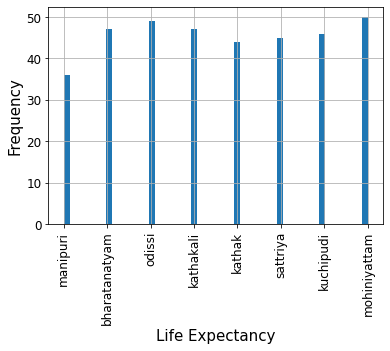

In [0]:
train_df['target'].hist(bins=50, grid=True, xlabelsize=12, ylabelsize=12)
plt.xlabel("Life Expectancy", fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Frequency",fontsize=15)

# **Random Image Dispaly**

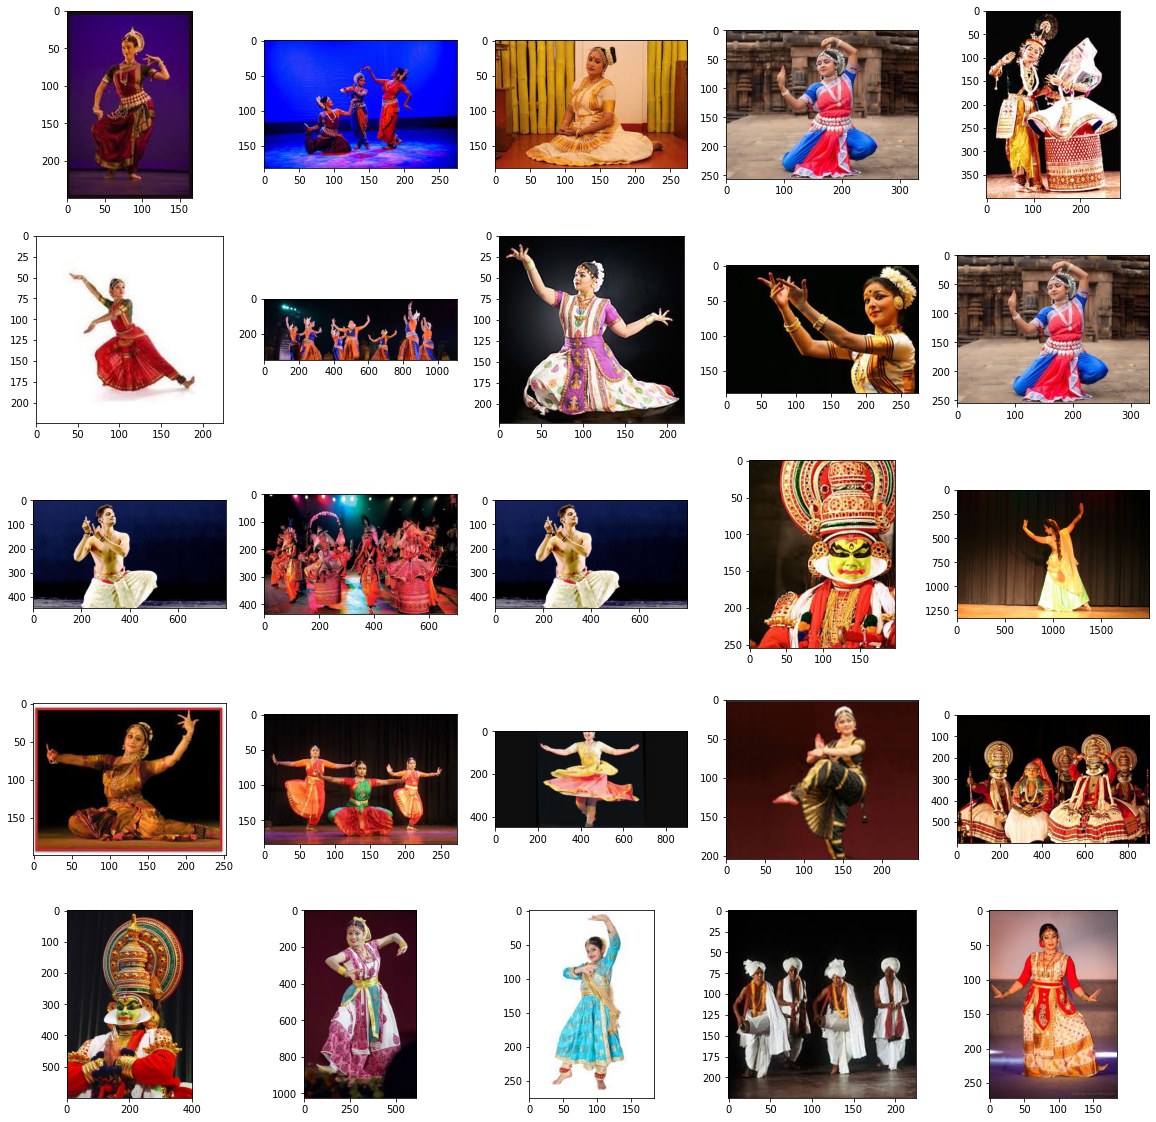

In [3]:
import numpy as np
import pathlib
from matplotlib.image import imread

images = train_df['Image'].values
rand_imgs = np.random.choice(images, size=5*5)
curr_dir= os.getcwd()
img_dir = "/content/drive/My Drive/dataset/train"
np.random.seed(42)
fig, axarr = plt.subplots(5, 5, figsize=(20, 20))

for i, rand_img in enumerate(rand_imgs):
    j = i // 5
    k = i % 5
    img = plt.imread(os.path.join(img_dir, rand_img))
    axarr[j][k].imshow(img,cmap='gray')
    axarr[j][k].grid(False)

# **Images Size Graph**

In [4]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
shapes = []
for img in rand_imgs:
    shapes.append(imread(os.path.join(img_dir,img)).shape)
    
shapes = pd.DataFrame().assign(X=pd.Series(shapes).map(lambda s: s[0]), Y=pd.Series(shapes).map(lambda s: s[1]))

In [7]:
sns.kdeplot

<function seaborn.distributions.kdeplot>

(0.0, 2256.65)

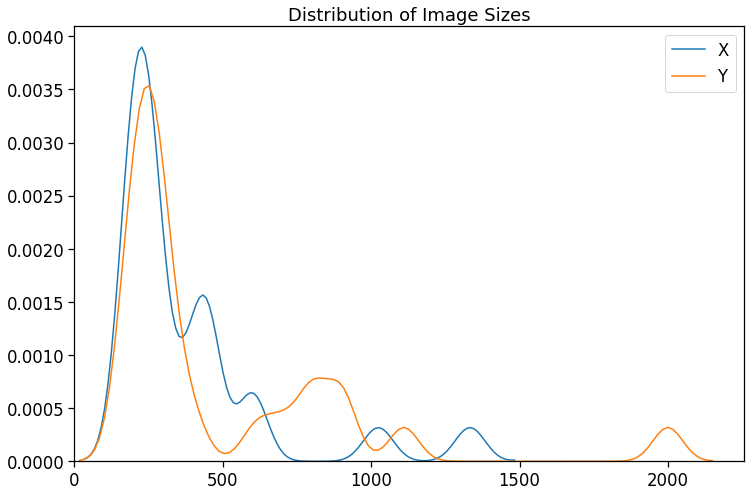

In [10]:
plt.figure(figsize=(12, 8))

sns.set_context("notebook", font_scale=1.5)
sns.kdeplot(shapes['X'], bw=50)
sns.kdeplot(shapes['Y'], bw=50)

plt.title('Distribution of Image Sizes')
ax = plt.gca()
ax.set_xlim(0, ax.get_xlim()[1])

# **Image Generators**

In [14]:
#Training Image Generator 
TRAINING_DIR = "/content/drive/My Drive/dataset/train"
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAINING_DIR,
    x_col="Image", # features
    y_col= "target", # labels
    class_mode="categorical", # 'Target' column should be in train_df
    batch_size= 16, # images per batch
    shuffle=False, # shuffle the rows or not
    target_size=(250,250), # width and height of output image
    subset='training'
)


# Validation Generator 
validation_generator = training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAINING_DIR,
    x_col="Image", # features
    y_col= "target", # labels
    class_mode="categorical", # 'Target' column should be in train_df
    batch_size= 16, # images per batch
    shuffle=False, # shuffle the rows or not
    target_size=(250,250), # width and height of output image
    subset='validation'
)


#Testing Image Generator 

TESTING_DIR = "/content/drive/My Drive/dataset/test"
testing_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_generator = training_datagen.flow_from_dataframe(
    dataframe=testing_df,
    directory=TESTING_DIR,
    x_col="Image", # features
    y_col= None, # labels
    class_mode=None, # 'Target' column should be in train_df
    batch_size= 16, # images per batch
    shuffle=False, # shuffle the rows or not
    target_size=(250,250) # width and height of output image
)


Found 292 validated image filenames belonging to 8 classes.
Found 72 validated image filenames belonging to 8 classes.
Found 156 validated image filenames.


In [0]:
train_num = train_generator.samples
print(train_num)

364


# **Custom Model**

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs={}): 
    if(logs.get('accuracy')>=0.9):
      print("\nReached 99.8% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:

callbacks = myCallback()
model = tf.keras.models.Sequential([
                                      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(84, 84, 3)),
                                      tf.keras.layers.MaxPooling2D(2, 2),
                                      # The second convolution
                                      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                      tf.keras.layers.MaxPooling2D(2,2),
                                      # The third convolution
                                      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                      tf.keras.layers.MaxPooling2D(2,2),
                                      # The fourth convolution
                                      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                      tf.keras.layers.MaxPooling2D(2,2),
                                      # Flatten the results to feed into a DNN
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dropout(0.5),
                                      # 512 neuron hidden layer
                                      tf.keras.layers.Dense(512, activation='relu'),
                                      tf.keras.layers.Dense(8, activation='softmax')
                                      ])
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(train_generator, epochs=200, steps_per_epoch=19,verbose = 1,callbacks=[callbacks],validation_data=validation_generator)
model.save("rps.h5")
print(history.epoch, history.history['accuracy'][-1])

# **VGG 16 Transfer Learning**


In [20]:
import os
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
callbacks = myCallback()
local_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

pre_trained_model =InceptionV3(input_shape = (320, 320, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

#pre_trained_model.summary()

--2020-05-31 12:23:38--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 2a00:1450:400c:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   135MB/s    in 0.6s    

2020-05-31 12:23:39 (135 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
pre_trained_model.summary()

In [24]:
#Taking output of the last layer 
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 18, 18, 768)


In [25]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense  (8, activation='sigmoid')(x)  
model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_generator, epochs=200, steps_per_epoch=19,verbose = 1,callbacks=[callbacks],validation_data=validation_generator)
model.save("mode84.h5")
print(history.epoch, history.history['accuracy'][-1])

11/19 [================>.............] - ETA: 4s - loss: 2.0726 - accuracy: 0.1402

KeyboardInterrupt: ignored

# Injectng new Layers to Model 84 

In [71]:
#Training Image Generator 
TRAINING_DIR = "/content/drive/My Drive/dataset/train"
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAINING_DIR,
    x_col="Image", # features
    y_col= "target", # labels
    class_mode="categorical", # 'Target' column should be in train_df
    batch_size= 16, # images per batch
    shuffle=False, # shuffle the rows or not
    target_size=(168,168), # width and height of output image
    subset='training'
)


# Validation Generator 
validation_generator = training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAINING_DIR,
    x_col="Image", # features
    y_col= "target", # labels
    class_mode="categorical", # 'Target' column should be in train_df
    batch_size= 16, # images per batch
    shuffle=False, # shuffle the rows or not
    target_size=(168,168), # width and height of output image
    subset='validation'
)


#Testing Image Generator 

TESTING_DIR = "/content/drive/My Drive/dataset/test"
testing_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_generator = training_datagen.flow_from_dataframe(
    dataframe=testing_df,
    directory=TESTING_DIR,
    x_col="Image", # features
    y_col= None, # labels
    class_mode=None, # 'Target' column should be in train_df
    batch_size= 16, # images per batch
    shuffle=False, # shuffle the rows or not
    target_size=(168,168) # width and height of output image
)


Found 292 validated image filenames belonging to 8 classes.
Found 72 validated image filenames belonging to 8 classes.
Found 156 validated image filenames.


In [0]:
#Load the pre-trained model
pre_train_48 = tf.keras.models.load_model('/content/mode84.h5')

model = tf.keras.models.Sequential([
                                      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(168, 168, 3),padding='same'),
                                      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(168, 168, 3),padding='same'),
                                      tf.keras.layers.MaxPooling2D(2, 2),
                                      ])


In [0]:
pre_train_48.summary()

In [0]:
for layer in pre_train_48.layers[2:]:
  model.add(layer)

In [0]:
model.summary()

In [0]:
for layer in pre_train_48.layers[-4:]:
    layer.trainable = False

In [0]:
model.compile(optimizer = RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_generator, epochs=200, steps_per_epoch=19,verbose = 1,callbacks=[callbacks],validation_data=validation_generator)
model.save("mode168.h5")
print(history.epoch, history.history['accuracy'][-1])

# Injecting Layer in Model 168 to get model 336

In [91]:
#Training Image Generator 
TRAINING_DIR = "/content/drive/My Drive/dataset/train"
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAINING_DIR,
    x_col="Image", # features
    y_col= "target", # labels
    class_mode="categorical", # 'Target' column should be in train_df
    batch_size= 16, # images per batch
    shuffle=False, # shuffle the rows or not
    target_size=(336,336), # width and height of output image
    subset='training'
)


# Validation Generator 
validation_generator = training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAINING_DIR,
    x_col="Image", # features
    y_col= "target", # labels
    class_mode="categorical", # 'Target' column should be in train_df
    batch_size= 16, # images per batch
    shuffle=False, # shuffle the rows or not
    target_size=(336,336), # width and height of output image
    subset='validation'
)


#Testing Image Generator 

TESTING_DIR = "/content/drive/My Drive/dataset/test"
testing_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_generator = training_datagen.flow_from_dataframe(
    dataframe=testing_df,
    directory=TESTING_DIR,
    x_col="Image", # features
    y_col= None, # labels
    class_mode=None, # 'Target' column should be in train_df
    batch_size= 16, # images per batch
    shuffle=False, # shuffle the rows or not
    target_size=(336,336) # width and height of output image
)


Found 292 validated image filenames belonging to 8 classes.
Found 72 validated image filenames belonging to 8 classes.
Found 156 validated image filenames.


In [0]:
#Load the pre-trained model
pre_train_ = tf.keras.models.load_model('/content/mode168.h5')

model = tf.keras.models.Sequential([
                                      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(336, 336, 3),padding='same'),
                                      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(336, 336, 3),padding='same'),
                                      tf.keras.layers.MaxPooling2D(2, 2),
                                      ])

In [0]:
for layer in pre_train_168.layers[1:]:
    #layer.name += '_pre_train'  # set layer names to avoid name collisions
    model.add(layer)

In [0]:
for layer in model.layers[-4:]:
    layer.trainable = False

In [0]:
model.compile(optimizer = RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_generator, epochs=200, steps_per_epoch=19,verbose = 1,callbacks=[callbacks],validation_data=validation_generator)
model.save("mode336.h5")
print(history.epoch, history.history['accuracy'][-1])

# **Statastic**

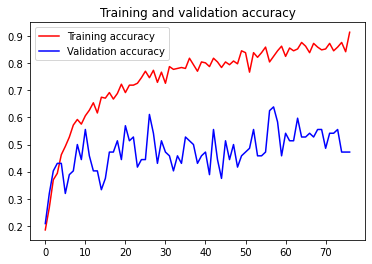

<Figure size 432x288 with 0 Axes>

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [0]:

shapes = []
for img in rand_imgs:
    shapes.append(imread(img).shape)
    
shapes = pd.DataFrame().assign(X=pd.Series(shapes).map(lambda s: s[0]), Y=pd.Series(shapes).map(lambda s: s[1]))



In [0]:
test_generator.reset()
pred=model.predict(test_generator,steps=10,verbose=1)

10/10 [==============================] - 4s 415ms/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
print(predicted_class_indices.shape)

(156,)


In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [0]:
filenames=test_generator.filenames
results=pd.DataFrame({"Image":filenames,
                      "target":predictions})
results.to_csv("results.csv",index=False)

In [0]:
cds=pd.read_csv("results.csv")

In [0]:
cds.head()

,Filename,Predictions
0,508.jpg,mohiniyattam
1,246.jpg,mohiniyattam
2,473.jpg,mohiniyattam
3,485.jpg,odissi
4,128.jpg,bharatanatyam


In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(320, 320))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving 11.jpg to 11.jpg
11.jpg
[[0. 1. 0. 0. 0. 0. 0. 0.]]
